In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from tqdm.notebook import tqdm

In [4]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# 1. Ошибки I и II рода при последовательном анализе.
## 1.1. Просто тест Стьюдента
Будем применять тест Стьдента постоянно по мере поступления данных.

Данные будем генерировать из нормальных распределений.

Проверим, что тест Стьюдента работает корректно при фиксированном размере выборки.

In [5]:
def get_sample_size(mu, std, eff=1.01, alpha=0.05, beta=0.2):
    t_alpha = abs(norm.ppf(alpha / 2, loc=0, scale=1))
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mu_diff_squared = (mu - mu * eff) ** 2
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    disp_sum = 2 * (std ** 2)
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * disp_sum / mu_diff_squared
        )
    )
    return sample_size

Оценим sample size

In [6]:
MEAN = 10
EFFECT = 1.03
STD = 1
ALPHA = 0.05
BETA = 0.2

sample_size = get_sample_size(mu=MEAN, std=STD, eff=EFFECT, alpha=ALPHA, beta=BETA)
print(f'sample_size = {sample_size}')

sample_size = 175


In [7]:
for _ in range(5):
    false_positive = []
    true_positive = []
    for _ in range(1000):
        data_a_one = np.random.normal(MEAN, STD, sample_size)
        data_a_two = np.random.normal(MEAN, STD, sample_size)
        data_b = np.random.normal(MEAN * EFFECT, STD, sample_size)
        _, pvalue_aa = stats.ttest_ind(data_a_one, data_a_two)
        _, pvalue_ab = stats.ttest_ind(data_a_one, data_b)
        false_positive.append(int(pvalue_aa < ALPHA))
        true_positive.append(int(pvalue_ab < ALPHA))
    print()
    print(f'I type error  : {np.mean(false_positive):0.3f}')
    print(f'II type error : {1 - np.mean(true_positive):0.3f}')


I type error  : 0.050
II type error : 0.216

I type error  : 0.051
II type error : 0.196

I type error  : 0.058
II type error : 0.189

I type error  : 0.043
II type error : 0.206

I type error  : 0.044
II type error : 0.227


#### последовательное тестирование
Добавляем по 1 наблюдению в каждую группу и проверяем значимость отличий.

Отклоняем нулевую гипотезу при первом попадании в критическую область.

Пусть у нас будет такой же объём данных как и при обычном тесте.

In [8]:
def test_sequential_simple(data_one, data_two, alpha):
    """Последовательно проверяет отличие по мере поступления данных.
    
    Возвращает 1, если были найдены значимые отличия, иначе - 0. И кол-во объектов при принятии решения.
    """
    min_len = min([len(data_one), len(data_two)])
    for i in range(2, min_len):
        sub_data_one = data_one[:i]
        sub_data_two = data_two[:i]
        _, pvalue = stats.ttest_ind(sub_data_one, sub_data_two)
        if pvalue < alpha:
            return 1, i
    return 0, i

In [9]:
for _ in range(5):
    false_positive = []
    true_positive = []
    for _ in range(200):
        data_a_one = np.random.normal(MEAN, STD, sample_size)
        data_a_two = np.random.normal(MEAN, STD, sample_size)
        data_b = np.random.normal(MEAN * EFFECT, STD, sample_size)
        false_positive.append(test_sequential_simple(data_a_one, data_a_two, ALPHA)[0])
        true_positive.append(test_sequential_simple(data_a_one, data_b, ALPHA)[0])
    print()
    print(f'I type error  : {np.mean(false_positive):0.3f}')
    print(f'II type error : {1 - np.mean(true_positive):0.3f}')


I type error  : 0.370
II type error : 0.075

I type error  : 0.410
II type error : 0.045

I type error  : 0.365
II type error : 0.075

I type error  : 0.440
II type error : 0.100

I type error  : 0.375
II type error : 0.065


Видим, что ошибка I рода выше, а ошибка II рода ниже того, что мы планировали получить.

То есть при последовательном тестировании нулевая гипотеза отклоняется чаще, нежели мы провели тест один раз в конце.

## 1.2. Тест Вальда.

In [13]:
# # Более понятная логика, когда имитируем в цикле постепенное получение данных. Но медленно.

# def test_sequential_wald(data_one, data_two, pdf_one, pdf_two, alpha, beta):
#     """Последовательно проверяет отличие по мере поступления данных.

#     pdf_one, pdf_two - функции плотности распределения при нулевой и альтернативной гипотезах
    
#     Возвращает 1, если были найдены значимые отличия, иначе - 0. И кол-во объектов при принятии решения.
#     """
#     lower_bound = np.log(beta / (1 - alpha))
#     upper_bound = np.log((1 - beta) / alpha)
    
#     min_len = min([len(data_one), len(data_two)])
#     for i in range(1, min_len):
#         sub_data_one = data_one[:i]
#         sub_data_two = data_two[:i]
#         delta_sub_data = sub_data_two - sub_data_one
#         pdf_one_values = pdf_one(delta_sub_data)
#         pdf_two_values = pdf_two(delta_sub_data)
#         z = np.sum(np.log(pdf_two_values / pdf_one_values))
#         if z < lower_bound:
#             return 0, i
#         if z > upper_bound:
#             return 1, i
#     return 0.5, i



# Более быстрая версия, которая использует векторные операции зная все данные.

def test_sequential_wald(data_one, data_two, pdf_one, pdf_two, alpha, beta):
    """Последовательно проверяет отличие по мере поступления данных.
    
    pdf_one, pdf_two - функции плотности распределения при нулевой и альтернативной гипотезах
    
    Возвращает 1, если были найдены значимые отличия, иначе - 0. И кол-во объектов при принятии решения.
    """
    lower_bound = np.log(beta / (1 - alpha))
    upper_bound = np.log((1 - beta) / alpha)
    
    min_len = min([len(data_one), len(data_two)])
    data_one = data_one[:min_len]
    data_two = data_two[:min_len]
    delta_data = data_two - data_one
    
    pdf_one_values = pdf_one(delta_data)
    pdf_two_values = pdf_two(delta_data)
    
    z = np.cumsum(np.log(pdf_two_values / pdf_one_values))
    
    indexes_lower = np.arange(min_len)[z < lower_bound]
    indexes_upper = np.arange(min_len)[z > upper_bound]
    first_index_lower = indexes_lower[0] if len(indexes_lower) > 0 else min_len + 1
    first_index_upper = indexes_upper[0] if len(indexes_upper) > 0 else min_len + 1
    
    if first_index_lower < first_index_upper:
        return 0, first_index_lower + 1
    elif first_index_lower > first_index_upper:
        return 1, first_index_upper + 1
    else:
        return 0.5, min_len

In [15]:
def pdf_one(x):
    """Функция плотности разницы средних при верности нулевой гипотезы."""
    return stats.norm.pdf(x, 0, np.sqrt(2) * STD)

def pdf_two(x):
    """Функция плотности разницы средних при верности альтернативной гипотезы."""
    return stats.norm.pdf(x, MEAN * (EFFECT - 1), np.sqrt(2) * STD)

def log_pdf_one(x):
    """Логарифм функции плотности разницы средних при верности нулевой гипотезы."""
    return stats.norm.logpdf(x, 0, np.sqrt(2) * STD)

def log_pdf_two(x):
    """Логарифм функции плотности разницы средних при верности альтернативной гипотезы."""
    return stats.norm.logpdf(x, MEAN * (EFFECT - 1), np.sqrt(2) * STD)

Смоделируем 100 АА тестов, построим график для статистики $\theta = mean(b) - mean(a)$. А также вернюю границу теста Вальда (rejected H0) и верхнюю границу обычного доверительного интервала.


In [10]:
MEAN = 10
EFFECT = 1.03
STD = 1
ALPHA = 0.05
BETA = 0.2

sample_size_ = 500

THETA = (EFFECT - 1) * MEAN
coef_ = 2 * STD**2 / THETA
array_steps = np.arange(2, sample_size_ + 1)
upper_bound_wald = coef_ * np.log((1 - BETA) / ALPHA) / array_steps + THETA / 2


# Вычисляет параметр функции распределения Стьюдента.
list_student_df = []
for step in array_steps:
    mean_one, mean_two = MEAN, MEAN
    std_one, std_two = STD / np.sqrt(step), STD / np.sqrt(step)
    student_df = (
        ((std_one ** 2) / step + (std_two ** 2) / step) ** 2
        / (
            (std_one ** 4) / ((step ** 2) * (step - 1))
            + (std_two ** 4) / ((step ** 2) * (step - 1))
        )
    )
    list_student_df.append(student_df)
# Верхняя граница критической области теста Стьюдента
upper_bound_student = np.array([
    stats.t.ppf(1 - ALPHA/2, df=df) * np.sqrt(2 / step)
    for df, step in zip(list_student_df, array_steps)
])

# генерируем данные
n_sample = 100
theta_means = np.zeros((n_sample, sample_size_))
for idx_sample in range(n_sample):
    data_a_one = np.random.normal(MEAN, STD, sample_size_)
    data_a_two = np.random.normal(MEAN, STD, sample_size_)
    delta = data_a_two - data_a_one
    theta_means[idx_sample] = np.cumsum(delta) / np.arange(1, sample_size_ + 1)
# будем смотреть на разность средних с момента появления второго наблюдения
theta_means = theta_means[:, 1:]

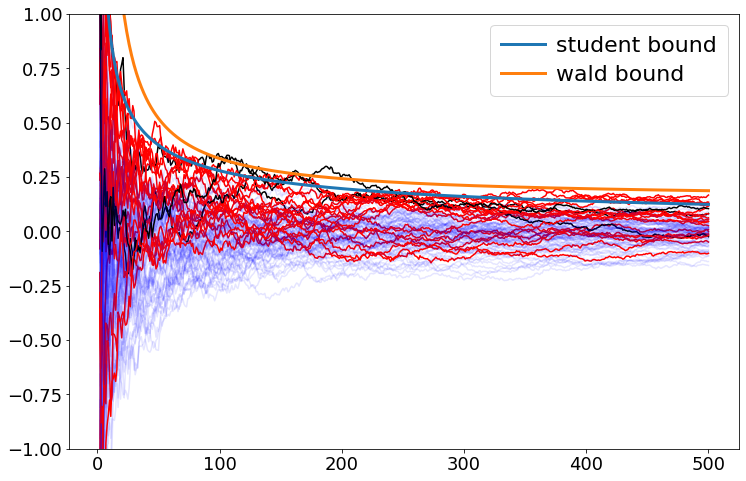

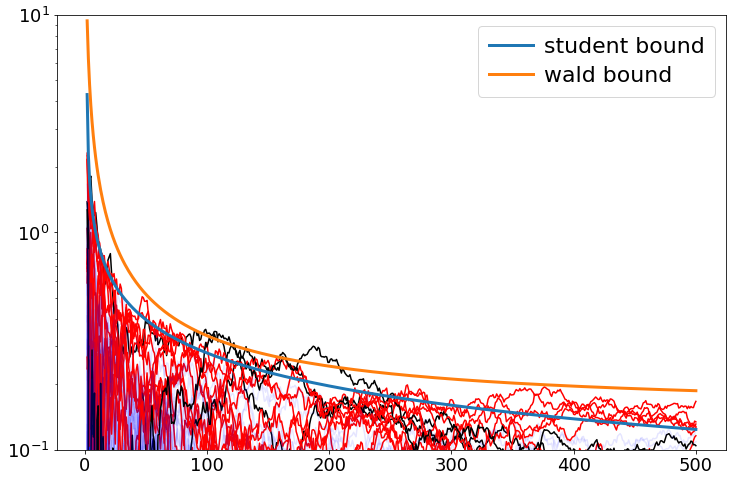

In [11]:
fog = plt.figure(figsize=[12, 8])

for curve in theta_means:
    if np.any(curve > upper_bound_wald):
        plt.plot(array_steps, curve,'k', alpha=1)
    elif np.any(curve > upper_bound_student):
        plt.plot(array_steps, curve,'r', alpha=1)
    else:
        plt.plot(array_steps, curve,'b', alpha=0.1)

plt.plot(array_steps, upper_bound_student, label='student bound', linewidth=3)
plt.plot(array_steps, upper_bound_wald, label='wald bound', linewidth=3)

plt.ylim([-1, 1])
plt.legend()
plt.show()




fog = plt.figure(figsize=[12, 8])

for curve in theta_means:
    if np.any(curve > upper_bound_wald):
        plt.plot(array_steps, curve,'k', alpha=1)
    elif np.any(curve > upper_bound_student):
        plt.plot(array_steps, curve,'r', alpha=1)
    else:
        plt.plot(array_steps, curve,'b', alpha=0.1)

plt.plot(array_steps, upper_bound_student, label='student bound', linewidth=3)
plt.plot(array_steps, upper_bound_wald, label='wald bound', linewidth=3)

plt.yscale('log')
plt.ylim([0.1, 10])
plt.legend()
plt.show()

Чёрные линии - траектории экпиериментов, которые показали значимый эффект для теста Вальда.

Красные - траектории экпиериментов, которые показали значимый эффект для последовательного применения теста Стьюдента, но не для теста Вальда.

Видно, что последовательный тест Стьдента допускает больше ошибок I рода, его граница находится ниже границы теста Вальда.

In [16]:
np.random.seed(42)

sample_size_ = 1000

for _ in range(5):
    false_positive = []
    true_positive = []
    list_length_aa = []
    list_length_ab = []
    for _ in range(200):
        data_a_one = np.random.normal(MEAN, STD, sample_size_)
        data_a_two = np.random.normal(MEAN, STD, sample_size_)
        data_b = np.random.normal(MEAN * EFFECT, STD, sample_size_)
        test_result_aa, length_aa = test_sequential_wald(
            data_a_one, data_a_two, pdf_one, pdf_two, ALPHA, BETA
        )
        test_result_ab, length_ab = test_sequential_wald(
            data_a_one, data_b, pdf_one, pdf_two, ALPHA, BETA
        )
        false_positive.append(test_result_aa)
        true_positive.append(test_result_ab)
        list_length_aa.append(length_aa)
        list_length_ab.append(length_ab)
    print()
    print(f'I type error  : {np.mean(false_positive):0.3f}')
    print(f'II type error : {1 - np.mean(true_positive):0.3f}')


I type error  : 0.045
II type error : 0.180

I type error  : 0.035
II type error : 0.215

I type error  : 0.035
II type error : 0.125

I type error  : 0.055
II type error : 0.165

I type error  : 0.070
II type error : 0.155


Тест Вальда контролирует ошибки на заданных уровнях.

# 2. Продолжительность теста
## 2.1. Фиксированные значения ошибок

Посмотрим как распределена продолжительность теста для случаев с эффектом и без эффекта.

In [17]:
np.random.seed(42)

sample_size_ = 1000
THETA = (EFFECT - 1) * MEAN

list_length_aa = []
list_length_ab = []

for _ in tqdm(range(1000)):
    data_a_one = np.random.normal(MEAN, STD, sample_size_)
    data_a_two = np.random.normal(MEAN, STD, sample_size_)
    data_b = np.random.normal(MEAN * EFFECT, STD, sample_size_)
    test_result_aa, length_aa = test_sequential_wald(
        data_a_one, data_a_two, pdf_one, pdf_two, ALPHA, BETA
    )
    test_result_ab, length_ab = test_sequential_wald(
        data_a_one, data_b, pdf_one, pdf_two, ALPHA, BETA
    )
    list_length_aa.append(length_aa)
    list_length_ab.append(length_ab)

mean length aa test: 68.0
mean length ab test: 90.6


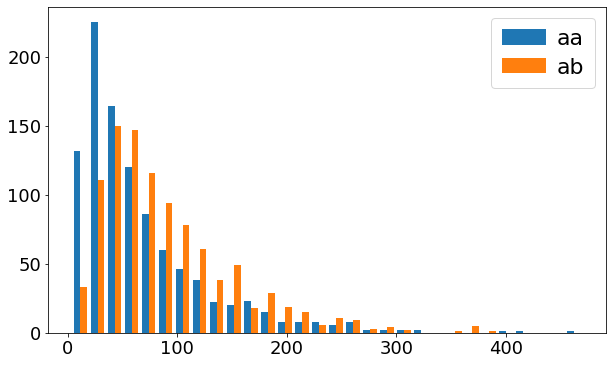

In [18]:
print(
    f'mean length aa test: {np.mean(list_length_aa):0.1f}\n'
    f'mean length ab test: {np.mean(list_length_ab):0.1f}'
)

plt.hist([list_length_aa, list_length_ab], bins=30, label=['aa', 'ab'])
plt.legend()
plt.show()

Последовательное тестирование в среднем останавливается раньше время проведеня обычного теста при верности одной из гипотез.

## 2.2. Посмотрим как влияют значения $\alpha$ и $\beta$ на продолжительность теста.

Посмотрим как меняется продолжительность теста при изменении значений допустимых вероятностей ошибок I и II рода.

In [19]:
errors = np.linspace(0.01, 0.3, 30)
sample_size_ = 1000

list_lengths = []

for error in tqdm(errors):
    alpha = beta = error
    lengths = []
    for _ in range(100):
        data_a_one = np.random.normal(MEAN, STD, sample_size_)
        data_a_two = np.random.normal(MEAN, STD, sample_size_)
        data_b = np.random.normal(MEAN * EFFECT, STD, sample_size_)
        _, length_aa = test_sequential_wald(
            data_a_one, data_a_two, pdf_one, pdf_two, alpha, beta
        )
        _, length_ab = test_sequential_wald(
            data_a_one, data_b, pdf_one, pdf_two, alpha, beta
        )
        lengths.append(length_aa)
        lengths.append(length_ab)
    list_lengths.append(lengths)

In [20]:
array_lengths = np.array(list_lengths)
means = np.mean(array_lengths, axis=1)
bounds = np.quantile(array_lengths, [0.05, 0.95], axis=1)

list_sample_size = [
    get_sample_size(mu=MEAN, std=STD, eff=EFFECT, alpha=error, beta=error)
    for error in errors
]

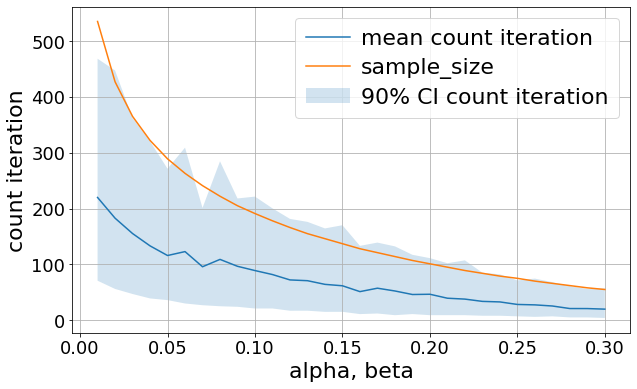

In [21]:
plt.plot(errors, means, label='mean count iteration')
plt.fill_between(errors, bounds[0], bounds[1], alpha=0.2, label='90% CI count iteration')
plt.plot(errors, list_sample_size, label='sample_size')

plt.xlabel('alpha, beta')
plt.ylabel('count iteration')
plt.legend()
plt.grid()

plt.show()

Ожидаемо тест останавливается за меньшее число итераций при увеличении допустимых ошибок I и II рода. Количество итераций при последовательном тестировании при разных ошибках I и II рода меньше чем при обычном тестировании.

## 2.3. Завышенный эффект
Как будет вести себя тест, если реальный эффект меньше ожидаемого?

Если реальный эффект больше ожидаемого или отрицательный, то тест быстрее отклонит одну из гипотез. А что если мы ожидаем эффект 3%, а он 2% или 1%. Посмотрим как это повлияет на частоту отклонения $H_0$ и продолжительность теста.

In [22]:
sample_size_ = 1000
bs_iter = 1000

effects = np.linspace(1, 1.04, 21)

list_lengths = []
list_results = []

for effect in tqdm(effects):
    lengths = []
    results = []
    array_data_a = np.random.normal(MEAN, STD, (bs_iter, sample_size_))
    array_data_b = np.random.normal(MEAN * effect, STD, (bs_iter, sample_size_))
    for data_a, data_b in zip(array_data_a, array_data_b):
        test_result, length = test_sequential_wald(
            data_a, data_b, pdf_one, pdf_two, ALPHA, BETA
        )
        lengths.append(length)
        results.append(test_result)
    list_lengths.append(lengths)
    list_results.append(results)

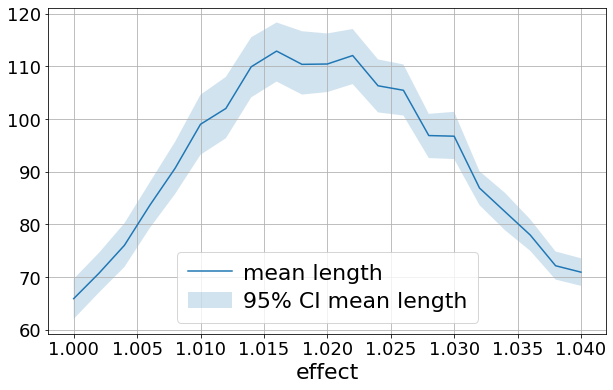

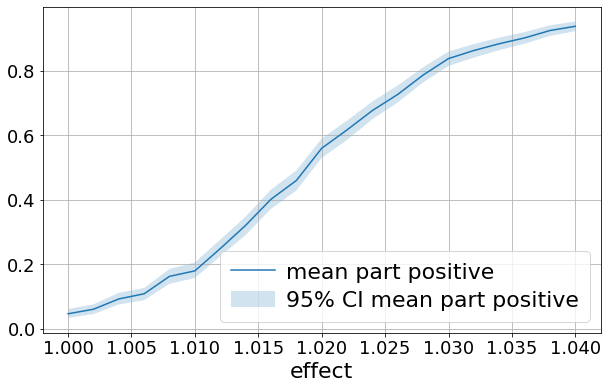

In [23]:
plot_data = [
    [list_lengths, 'length'],
    [list_results, 'part positive']
]

for list_data, label in plot_data:
    array_data = np.array(list_data)
    means = np.mean(array_data, axis=1)
    bs_mean = np.array([
        row[np.random.randint(0, len(row), [1000, len(row)])].mean(axis=1)
        for row in array_data
    ])
    bounds = np.quantile(bs_mean, [0.025, 0.975], axis=1)
    plt.plot(effects, means, label=f'mean {label}')
    plt.fill_between(effects, bounds[0], bounds[1], label=f'95% CI mean {label}', alpha=0.2)
    
    plt.legend()
    plt.grid()
    plt.xlabel('effect')
    
    plt.show()

Из первого графика видно, что тест Вальда останавливается в среднем за большее число шагов, когда реальный эффект находится между ожидаемыми эффектами при H0 и H1. Но среднее объём данных всё равно меньше объёма данных для классического теста = 175.

Вероятность отклонения нулевой гипотезы при увеличении реального эффект увеличивается.

# 3. Поступление данных батчами.
Посмотрим как будет меняться ошибки I и II рода и необходимый объём данных при поступлении данных батчами.

In [24]:
def test_sequential_wald_batch(data_one, data_two, pdf_one, pdf_two, alpha, beta, batch_size=1):
    """Последовательно проверяет отличие по мере поступления данных.

    pdf_one, pdf_two - функции плотности распределения при нулевой и альтернативной гипотезах
  
    Возвращает 1, если были найдены значимые отличия, иначе - 0. И кол-во объектов при принятии решения.
    """
    lower_bound = np.log(beta / (1 - alpha))
    upper_bound = np.log((1 - beta) / alpha)
    
    min_len = min([len(data_one), len(data_two)])
    min_len = min_len - min_len % batch_size
    len_batch = min_len // batch_size

    data_one = data_one[:min_len]
    data_two = data_two[:min_len]
    delta_data = data_two - data_one
    
    pdf_one_values = pdf_one(delta_data)
    pdf_two_values = pdf_two(delta_data)
    
    log_likelihood_ratio = np.log(pdf_two_values / pdf_one_values)
    log_likelihood_ratio_batch = (
        log_likelihood_ratio
        .reshape(min_len // batch_size,  batch_size)
        .sum(axis=1)
    )


    z = np.cumsum(log_likelihood_ratio_batch)

    indexes_lower = np.arange(len_batch)[z < lower_bound]
    indexes_upper = np.arange(len_batch)[z > upper_bound]
    first_index_lower = indexes_lower[0] if len(indexes_lower) > 0 else min_len + 1
    first_index_upper = indexes_upper[0] if len(indexes_upper) > 0 else min_len + 1
    
    if first_index_lower < first_index_upper:
        return 0, (first_index_lower + 1) * batch_size
    elif first_index_lower > first_index_upper:
        return 1, (first_index_upper + 1) * batch_size
    else:
        return 0.5, min_len

In [25]:
np.random.seed(42)

batch_sizes = [1] + list(range(25, 176, 25))
sample_size_ = 10000

metric_names = ['false_positive', 'false_negative', 'list_length']

res = {
    metric_name: {
        batch_size: [] for batch_size in batch_sizes
    }
    for metric_name in metric_names
}


for _ in tqdm(range(1000)):
    data_a_one = np.random.normal(MEAN, STD, sample_size_)
    data_a_two = np.random.normal(MEAN, STD, sample_size_)
    data_b = np.random.normal(MEAN * EFFECT, STD, sample_size_)
    
    for batch_size in batch_sizes:
        test_result_aa, length_aa = test_sequential_wald_batch(
            data_a_one, data_a_two, pdf_one, pdf_two, ALPHA, BETA, batch_size
        )
        test_result_ab, length_ab = test_sequential_wald_batch(
            data_a_one, data_b, pdf_one, pdf_two, ALPHA, BETA, batch_size
        )
        res['false_positive'][batch_size].append(test_result_aa)
        res['false_negative'][batch_size].append(1 - test_result_ab)
        res['list_length'][batch_size].append(length_aa)
        res['list_length'][batch_size].append(length_ab)

In [26]:
agg_res = {
    metric_name: {'mean': [], 'lower': [], 'upper': []}
    for metric_name in metric_names
}

for metric_name, metric_data in res.items():
    for batch_size, batch_data in metric_data.items():
        mean_ = np.mean(batch_data)

        bs_mean = (
            np.random.choice(batch_data, [1000, len(batch_data)])
            .mean(axis=1)
        )
        lower_, upper_ = np.quantile(bs_mean, [0.05, 0.95])
        
        agg_res[metric_name]['mean'].append(mean_)
        agg_res[metric_name]['lower'].append(lower_)
        agg_res[metric_name]['upper'].append(upper_)

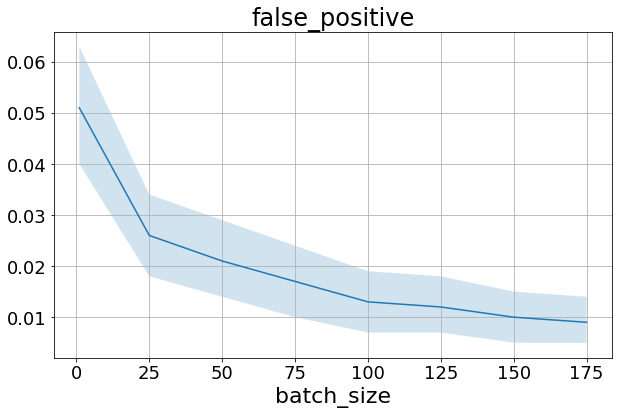

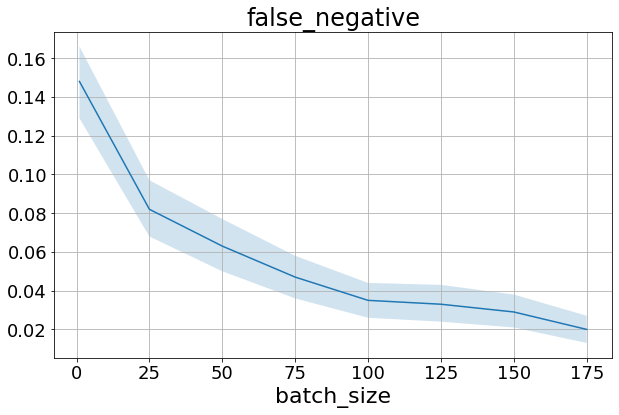

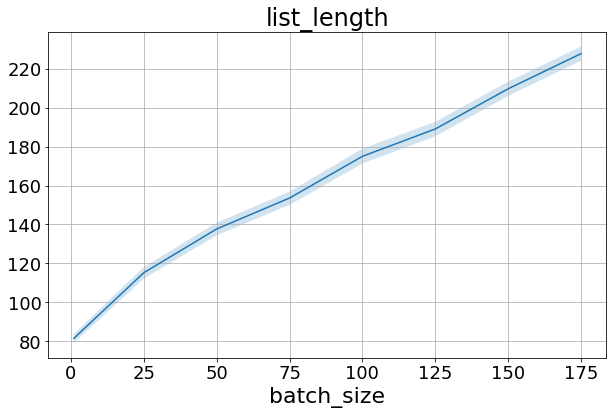

In [27]:
for metric_name, metric_agg_data in agg_res.items():
    plt.plot(batch_sizes, metric_agg_data['mean'])
    plt.fill_between(batch_sizes, metric_agg_data['lower'], metric_agg_data['upper'], alpha=0.2)
    plt.title(metric_name)

    plt.xlabel('batch_size')
    plt.grid()
    plt.show()

Видно что при границах, рассчитанных для добавления элементов по одному, при увеличении размера батчей ошибки уменьшаются и увеличивается продолжительность теста.

При поступлении данных под одному наблюдению в какой-то момент статистика могла выйти за границу критерия и тест остановился бы. Но если продолжить наблюдения, то статистика может опять вергуться в допустимые границы. При добавлении данных батчами измерения усредняются, и такие выбросы, выводящие за границу критерия, могут быть пропущены. Поэтому чаще принимается решение о продолжении эксперимента. А имея большее кол-во данных мы снижаем верятности ошибок.